In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%config Completer.use_jedi = False

# SpikeInterface pipeline for Movshon Lab - Blackrock

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw

## 1) Load recordings, compute LFP, and inspect signals

In [3]:
# Data files directory
dir_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/data_blackrock')

# Test if file exists
file_path = dir_path / 'XX_LE_textures_20191128_002.ns6'
print(f'File exists: {file_path.is_file()}')

# Spikeinterface directory
dir_spikeinterface = dir_path / "spikeinterface"
dir_spikeinterface.mkdir(parents=True, exist_ok=True)
print(dir_spikeinterface)

File exists: True
/home/luiz/storage/taufferconsulting/client_ben/project_movshon/data_blackrock/spikeinterface


In [4]:
# Choose Blackrock extension (ns*) to be used
nsx_to_load = 6

# Create recording extractor
recording = se.BlackrockRecordingExtractor(
    filename=str(file_path),
    nsx_to_load=nsx_to_load
)

# Set individual groups
#recording.set_channel_groups(range(recording.get_num_channels()))

### Stub recording for fast testing; set to False for running processing pipeline on entire data

In [5]:
print(f"Num channels: {recording.get_num_channels()}")
print(f"Sampling rate: {recording.get_sampling_frequency()}")
print(f"Duration (s): {recording.get_num_frames() / recording.get_sampling_frequency()}")

Num channels: 192
Sampling rate: 30000.0
Duration (s): 1942.1709333333333


### Compute LFP

In [6]:
freq_min_lfp = 1
freq_max_lfp = 300
freq_resample_lfp = 1000.

# Apply bandpass filter
recording_lfp = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_lfp, freq_max=freq_max_lfp)

# Resample lfp
recording_lfp = st.preprocessing.resample(recording_lfp, freq_resample_lfp)

print(f"Sampling frequency Raw: {recording.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lfp.get_sampling_frequency()}")   

Sampling frequency Raw: 30000.0
Sampling frequency LF: 1000.0


### Inspect signals

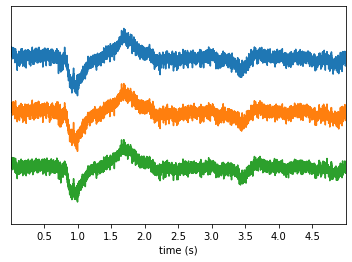

In [7]:
w_ts_raw = sw.plot_timeseries(recording, trange=[0, 5], channel_ids=[1, 2, 3])

In [8]:
# w_ts_lf = sw.plot_timeseries(recording_lfp, trange=[10, 15])

## 2) Pre-processing

In [9]:
apply_filter = True
apply_cmr = True
freq_min_hp = 300
freq_max_hp = 3000

In [10]:
if apply_filter:
    recording_processed = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_hp, freq_max=freq_max_hp)
else:
    recording_processed = recording

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)
    
# Stub recording for fast testing; set to False for running processing pipeline on entire data
stub_test = True
nsec_stub = 20
subr_ids = [i + 1 for i in range(10)]
if stub_test:
    recording_processed = se.SubRecordingExtractor(
        parent_recording=recording_processed, 
        channel_ids=subr_ids,
        end_frame=int(nsec_stub*recording_processed.get_sampling_frequency())
    )
    recording_lfp = se.SubRecordingExtractor(recording_lfp, end_frame=int(nsec_stub*recording_lfp.get_sampling_frequency()))
    
print(f"Original signal length: {recording.get_num_frames()}")
print(f"Processed signal length: {recording_processed.get_num_frames()}")

Original signal length: 58265128
Processed signal length: 600000


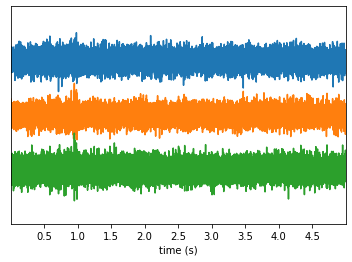

In [11]:
w_ts_processed = sw.plot_timeseries(recording_processed, trange=[0, 5], channel_ids=[1, 2, 3])

## 3) Run spike sorters

In [12]:
ss.installed_sorters()

['herdingspikes', 'klusta']

In [13]:
sorter_list = ['klusta']

# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))

klusta params description:
{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the '
                'sign of the spikes in the recording',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)',
 'num_starting_clusters': 'Number of initial clusters',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection'}
Default params:
{'adjacency_radius': None,
 'chunk_mb': 500,
 'detect_sign': -1,
 'extract_s_after': 32,
 'extract_s_before': 16,
 'n_features_per_channel': 3,


In [14]:
# Choose which recording to use for sorting
rec_to_sort = recording_processed

# spike sort by group
sorting = ss.run_klusta(
    recording=rec_to_sort, 
    grouping_property='group',
    output_folder=dir_spikeinterface / "si_output",
)

WARNING! No channel location given. Add dummy location.
RUNNING SHELL SCRIPT: /home/luiz/storage/taufferconsulting/client_ben/project_movshon/data_blackrock/spikeinterface/si_output/0/run_klusta.sh


## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

### Set postprocessing parameters

In [15]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
pprint(postprocessing_params)

OrderedDict([('max_spikes_per_unit', 300),
             ('recompute_info', False),
             ('save_property_or_features', True),
             ('memmap', True),
             ('seed', 0),
             ('verbose', False),
             ('joblib_backend', 'loky')])


In [16]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted

### Set quality metric list

In [17]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'isi_violation', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', 'l_ratio', 'd_prime', 'noise_overlap', 'nn_hit_rate', 'nn_miss_rate']


In [18]:
# (optional) define subset of qc
qc_list = ["snr", "isi_violation", "firing_rate"]

### Set extracellular features

In [19]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

Available EC features: ['peak_to_valley', 'halfwidth', 'peak_trough_ratio', 'repolarization_slope', 'recovery_slope']


In [20]:
# (optional) define subset of ec
ec_list = ["peak_to_valley", "halfwidth"]

### Postprocess all sorting outputs

In [21]:
# st.validation.compute_quality_metrics?

In [22]:
tmp_folder = dir_spikeinterface / 'tmp' / 'klusta'
tmp_folder.mkdir(parents=True, exist_ok=True)

# set local tmp folder
sorting.set_tmp_folder(tmp_folder)

# compute waveforms
waveforms = st.postprocessing.get_unit_waveforms(rec_to_sort, sorting, **postprocessing_params)

# compute templates
templates = st.postprocessing.get_unit_templates(rec_to_sort, sorting, **postprocessing_params)

# comput EC features
ec = st.postprocessing.compute_unit_template_features(rec_to_sort, sorting,
                                                      feature_names=ec_list, as_dataframe=True)
# compute QCs
qc = st.validation.compute_quality_metrics(sorting, recording=rec_to_sort, 
                                           metric_names=qc_list, as_dataframe=True)

# export to phy
phy_folder = dir_spikeinterface / 'phy' / 'klusta'
phy_folder.mkdir(parents=True, exist_ok=True)
st.postprocessing.export_to_phy(rec_to_sort, sorting, phy_folder)

Text(0, 0.5, 'Avg spike trace per channel')

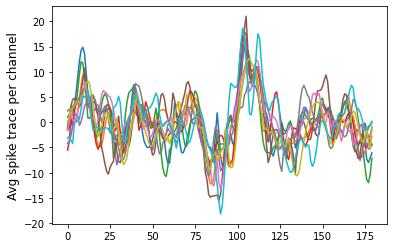

In [23]:
# Visualize spike template waverforms
unit_id = 0

plt.figure()
spk = np.squeeze(templates[unit_id])
plt.plot(spk.T)
plt.ylabel('Avg spike trace per channel', fontsize=12)

## 5) Compare with baseline - Extracting sorted spikes from Blackrock .nev

In [24]:
spikes_file = str(dir_path / 'XX_LE_textures_20191128_002.nev')

br_spike_extractor = se.BlackrockSortingExtractor(
    filename=spikes_file, 
    nsx_to_load=6
)

In [25]:
cmp_KL_BR = sc.compare_two_sorters(
    sorting1=sorting, sorting2=br_spike_extractor,
    sorting1_name='klusta', sorting2_name='blackrock'
)

In [26]:
# sw.plot_agreement_matrix(cmp_KL_BR)
cmp_KL_BR.agreement_scores

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.004634,0.002623,0.003939,0.002977,0.003114,0.003780,0.003834,0.004484,0.004193,0.003605,...,0.000366,0.0,0.0,0.00028,0.0,0.0,0.0,0.000252,0.0,0.000332
3,0.000191,0.000134,0.000000,0.000000,0.000218,0.000161,0.000077,0.000000,0.000181,0.001541,...,0.000000,0.0,0.0,0.00019,0.0,0.0,0.0,0.000085,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.001326,0.000000,0.000210,0.000061,0.000111,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000086,0.0,0.000000


# 6) Automatic curation

In [27]:
# define curators and thresholds
isi_violation_threshold = 0.5
snr_threshold = 5
firing_rate_threshold = 0.1

In [28]:
num_frames = rec_to_sort.get_num_frames()

# firing rate threshold
sorting_curated = st.curation.threshold_firing_rates(
    sorting,
    duration_in_frames=num_frames,
    threshold=firing_rate_threshold, 
    threshold_sign='less'
)

# isi violation threshold
sorting_curated = st.curation.threshold_isi_violations(
    sorting,
    duration_in_frames=num_frames,
    threshold=isi_violation_threshold, 
    threshold_sign='greater'
)

# isi violation threshold
sorting_curated = st.curation.threshold_snrs(
    sorting,
    recording=recording_processed,
    threshold=snr_threshold, 
    threshold_sign='less'
)

# 7) Quick save to NWB

To complete the full conversion with other types of data and extended options, use a NWB Converter class

In [31]:
from nwb_conversion_tools.utils.spike_interface import write_recording, write_sorting

output_nwb = 'blackrock_si_results.nwb'

write_recording(
    recording=rec_to_sort,
    save_path=output_nwb,
    overwrite=True
)

write_sorting(
    sorting=sorting,
    save_path=output_nwb,
    overwrite=False
)

/home/luiz/anaconda3/envs/env_movshon/lib/python3.7/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/home/luiz/anaconda3/envs/env_movshon/lib/python3.7/site-packages/hdmf/common/table.py:415: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)
/media/luiz/storage/Github/nwb-conversion-tools/nwb_conversion_tools/utils/spike_interface.py:984: UserWarning: Description for property group not found in property_descriptions. Setting description to 'no description'
  f"Description for property {pr} not found in property_descriptions. "
/home/luiz/anaconda3/envs/env_movshon/lib/python3.7/site-packages/hdmf/build/objectmapper.py:256: DtypeConversionWarning: Spec 'Units/VectorData': Value 

In [32]:
# Check NWB file with widgets
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget

io = NWBHDF5IO(output_nwb, 'r')
nwbfile = io.read()
nwb2widget(nwbfile)

/home/luiz/anaconda3/envs/env_movshon/lib/python3.7/site-packages/hdmf/common/table.py:415: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)
